## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [6]:
# pandas and numpy
import pandas as pd
import numpy as numpy

# punctuation, spacy, stop words and English language model
from string import punctuation
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Image, en_core_web_sm, scattertext, WordCloud, STOPWORDS, ImageColorGenerator, 
from PIL import Image
import en_core_web_sm
import scattertext as st
nlp = en_core_web_sm.load()
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [7]:
congress_tweets = pd.read_csv("116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
#congress_tweets = congress_tweets.sample(...)
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.081010e+18,RepByrne,2019-01-03T21:23:00-05:00,Great news for Baldwin County! The economy of ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
1,1.080880e+18,RepByrne,2019-01-03T12:30:38-05:00,Outstanding news today from @Airbus! @JetBlue ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
2,1.080830e+18,RepByrne,2019-01-03T09:12:07-05:00,RT @senatemajldr Democrats will have to get se...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
3,1.080890e+18,RepByrne,2019-01-03T13:20:53-05:00,Here is a sign of things to come: As Democrats...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
4,1.080870e+18,RepByrne,2019-01-03T12:10:26-05:00,Let's understand what we're dealing with here:...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"


In [8]:
congress_tweets=congress_tweets.drop(['tweet_id', 'screen_name'],axis=1)

In [9]:
congress_tweets

,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,2019-01-03T21:23:00-05:00,Great news for Baldwin County! The economy of ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
1,2019-01-03T12:30:38-05:00,Outstanding news today from @Airbus! @JetBlue ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
2,2019-01-03T09:12:07-05:00,RT @senatemajldr Democrats will have to get se...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
3,2019-01-03T13:20:53-05:00,Here is a sign of things to come: As Democrats...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
4,2019-01-03T12:10:26-05:00,Let's understand what we're dealing with here:...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946786,2020-12-25T08:15:00-05:00,"From our family to yours, we wish you a very M...",Liz Cheney,Rep,3-Jan-17,7/28/1966,F,WY,0,Republican,"174,419","55,973","69,286","170,962"
946787,2020-12-25T09:04:53-05:00,Bobbi and I wish everyone a wonderful Christma...,John Barrasso,Sen,3-Jan-19,7/21/1952,M,WY,Senate,Republican,"174,419","55,973","69,286","170,962"
946788,2020-12-28T11:20:02-05:00,God bless the six brave law enforcement office...,Liz Cheney,Rep,3-Jan-17,7/28/1966,F,WY,0,Republican,"174,419","55,973","69,286","170,962"
946789,2021-01-01T08:15:00-05:00,Wishing a healthy and very happy New Year to e...,Liz Cheney,Rep,3-Jan-17,7/28/1966,F,WY,0,Republican,"174,419","55,973","69,286","170,962"


## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [10]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith(('http', 'RT'))]
    
    #spacy_words2 = [token.text.lower() for token in doc]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [11]:
text = congress_tweets['text'][2]

In [12]:
tokens_reduced = rem_punc_stop(text)
tokens_reduced

['senatemajldr',
 'Democrats',
 'border',
 'security',
 'government',
 'funding',
 'agreement',
 'pass',
 'House',
 'earn',
 '60',
 'votes',
 'Senate',
 'receive',
 'presidential',
 'signature',
 'All',
 'things',
 'needed',
 'One',
 'partisan',
 'vote',
 'House',
 'wo',
 'nt',
 'solve']

In [13]:
numpy.random.seed(10)
ct_sub = congress_tweets.sample(n=3000)

In [14]:
ct_sub

,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
36257,2020-06-25T10:22:13-04:00,"Before adopting Olivia, we spent a great amoun...",David Schweikert,Rep,3-Jan-13,3/3/1962,M,AZ,6,Republican,"1,252,401","1,161,167","1,025,232","1,233,654"
548996,2019-01-07T09:33:39-05:00,Are we supposed to take Trump seriously or lit...,Sean Patrick Maloney,Rep,3-Jan-13,7/30/1966,M,NY,18,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"
652347,2020-10-30T16:24:14-04:00,Thank you to Lieutenant Mike Tarr and Fire Chi...,Steve Chabot,Rep,3-Jan-11,1/22/1953,M,OH,1,Republican,"2,841,005","2,394,164","2,827,709","2,661,437"
267614,2019-03-07T13:33:23-05:00,Made remarks to @AmFreeSyria sharing my concer...,Jim Risch,Sen,3-Jan-09,5/3/1943,M,ID,Senate,Republican,"409,055","189,765","212,787","420,911"
344386,2019-02-17T23:35:06-05:00,@jeroneanderson @MontcoLP @LelandShow @realDon...,Thomas Massie,Rep,13-Nov-12,1/13/1971,M,KY,4,Republican,"1,202,971","628,854","679,370","1,087,190"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289949,2019-12-20T09:38:54-05:00,That’s one reason why I’m proud to have secure...,Tammy Duckworth,Sen,3-Jan-17,3/12/1968,F,IL,Senate,Democrat,"2,146,015","3,090,729","3,019,512","2,135,216"
590720,2020-05-07T15:20:53-04:00,"We need more funds for #EIDL and, in meantime,...",Nydia Velázquez,Rep,3-Jan-13,3/28/1953,F,NY,7,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"
601127,2020-09-04T09:49:40-04:00,A strong US economic recovery is well underway...,Lee Zeldin,Rep,3-Jan-15,1/30/1980,M,NY,1,Republican,"2,819,533","4,556,118","4,485,741","2,490,431"
264039,2020-08-25T16:22:34-04:00,The Savannah Harbor Expansion Project is on tr...,David Perdue,Sen,3-Jan-15,12/10/1949,M,GA,Senate,Republican,"2,089,104","1,877,963","1,773,827","2,078,688"


In [15]:
ct_sub['tokens'] = ct_sub['text'].map(lambda x: rem_punc_stop(x))
ct_sub['tokens']

36257     [Before, adopting, Olivia, spent, great, time,...
548996    [Are, supposed, Trump, seriously, literally, s...
652347    [Thank, Lieutenant, Mike, Tarr, Fire, Chief, O...
267614    [Made, remarks, AmFreeSyria, sharing, concern,...
344386    [jeroneanderson, MontcoLP, LelandShow, realDon...
                                ...                        
289949    [That, reason, I, proud, secured, provisions, ...
590720    [We, need, funds, EIDL, meantime, SBAGov, queu...
601127    [A, strong, US, economic, recovery, underway, ...
264039    [The, Savannah, Harbor, Expansion, Project, tr...
720271    [RIHEALTH, GovRaimondo, All, customerfacing, b...
Name: tokens, Length: 3000, dtype: object

In [48]:
ct_sub['tokens_str'] = ct_sub['tokens'].map(lambda text: ' '.join(text))

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered <u>word frequencies,</u> <u>word clouds,</u> <u>word/character counts,</u> <u>scattertext,</u> and <u>topic modeling</u> as possible exploration tools. 

### EDA 1 - Word Cloud

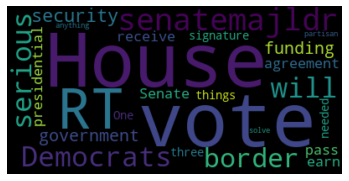

In [16]:
wordtext = ' '.join(ct_sub['tokens'].map(lambda wordtext: ' '.join(wordtext)))
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show() 

### EDA 2 - Topic Modeling 

#### Part 1: 5 components

In [17]:
#create  tf-idf matrix
X = ct_sub['text']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)

tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense() 

In [18]:
#apply LDA model with hyperparameter n_components = 5
lda = LatentDirichletAllocation(n_components=5, max_iter=20, random_state=0)
lda = lda.fit(dense_matrix)

In [19]:
#print topics
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [20]:
#print top words
tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names, 20)


Topic #0:


 
 amp rt qt president trump today country vote health need people help time work care new covid19 nt

Topic #1:


 rt 
 amp today act health trump people senate   house qt “ covid19 bill ” need care country

Topic #2:


 amp rt 
   today president people qt health american work realdonaldtrump 
 
 impeachment trump house support need time

Topic #3:


 amp 
 today rt act day help qt house covid19 need congress families president bipartisan bill new thank  

Topic #4:


 rt   amp today 
 need people workers trump time covid19 bill small care health president qt new read



In [21]:
#compare prevalence of each topic across documents

#get topic distribution array
topic_dist = lda.transform(tfidf_matrix)
topic_dist

array([[0.03251607, 0.03206961, 0.03271567, 0.03342197, 0.86927669],
       [0.04931448, 0.0490108 , 0.8035473 , 0.04909528, 0.04903214],
       [0.04936609, 0.04977347, 0.80155263, 0.04937155, 0.04993625],
       ...,
       [0.03770616, 0.03796852, 0.84853965, 0.03806753, 0.03771814],
       [0.04708401, 0.04690296, 0.0499096 , 0.04746615, 0.80863728],
       [0.03683849, 0.03849082, 0.03799161, 0.03710056, 0.84957852]])

In [32]:
#merge back with original df
topic_dist_df = pd.DataFrame(topic_dist)
df_w_topics = topic_dist_df.join(ct_sub.reset_index())
df_w_topics.head()

,0,1,2,3,4,5,6,7,8,9,...,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,0.015611,0.015620,0.015618,0.015611,0.015607,0.015608,0.015607,0.859497,0.015610,0.015612,...,3/3/1962,M,AZ,6,Republican,"1,252,401","1,161,167","1,025,232","1,233,654","[Before, adopting, Olivia, spent, great, time,..."
1,0.024326,0.781072,0.024325,0.024324,0.024326,0.024324,0.024328,0.024326,0.024325,0.024324,...,7/30/1966,M,NY,18,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[Are, supposed, Trump, seriously, literally, s..."
2,0.024517,0.024514,0.024515,0.024514,0.024516,0.024516,0.779365,0.024516,0.024514,0.024512,...,1/22/1953,M,OH,1,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[Thank, Lieutenant, Mike, Tarr, Fire, Chief, O..."
3,0.017026,0.017027,0.017029,0.017029,0.017026,0.846744,0.017027,0.017038,0.017028,0.017027,...,5/3/1943,M,ID,Senate,Republican,"409,055","189,765","212,787","420,911","[Made, remarks, AmFreeSyria, sharing, concern,..."
4,0.026858,0.026859,0.026862,0.758258,0.026861,0.026861,0.026859,0.026860,0.026862,0.026858,...,1/13/1971,M,KY,4,Republican,"1,202,971","628,854","679,370","1,087,190","[jeroneanderson, MontcoLP, LelandShow, realDon..."


In [23]:
#check average weight of each topic across party using group by
grouped = df_w_topics.groupby('party')
for i in range(0, 5):
    print(grouped[i].mean().sort_values(ascending=False))

party
Republican     0.183230
Democrat       0.182115
Independent    0.161849
Name: 0, dtype: float64
party
Democrat       0.190291
Republican     0.189309
Independent    0.037989
Name: 1, dtype: float64
party
Independent    0.294099
Republican     0.239504
Democrat       0.220691
Name: 2, dtype: float64
party
Independent    0.345383
Democrat       0.210186
Republican     0.191599
Name: 3, dtype: float64
party
Democrat       0.196717
Republican     0.196358
Independent    0.160679
Name: 4, dtype: float64


In [24]:
#check average weight of each topic across position using group by
grouped = df_w_topics.groupby('position')
for i in range(0, 5):
    print(grouped[i].mean().sort_values(ascending=False))

position
Rep    0.183967
Sen    0.177419
Name: 0, dtype: float64
position
Sen    0.190401
Rep    0.188938
Name: 1, dtype: float64
position
Sen    0.236231
Rep    0.225024
Name: 2, dtype: float64
position
Rep    0.204825
Sen    0.202145
Name: 3, dtype: float64
position
Rep    0.197246
Sen    0.193804
Name: 4, dtype: float64


<b> What do we see so far? </b>
With n_components = 5, we don't really see much separation for either party or position.  Going to retrain LDA with more topics, n_topics = 10. 

### EDA 2 - Topic Modeling 

#### Part 2: 10 components

In [25]:
#apply LDA model with hyperparameter n_components = 10
lda_10 = LatentDirichletAllocation(n_components=10, max_iter=20, random_state=0)
lda_10 = lda_10.fit(dense_matrix)

In [26]:
#print topics
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [27]:
#print top words
tf_feature_names = tf.get_feature_names()
print_top_words(lda_10, tf_feature_names, 20)


Topic #0:


 
 president amp rt thank today year trump qt public family ” “ hall great town like political time

Topic #1:


 rt 
   qt need amp today senate “ time president ” act work energy support federal students bill

Topic #2:


 rt amp   
 today president people realdonaldtrump ️ congress provide want americans qt help need read covid19 women

Topic #3:


 amp rt today 
   bipartisan 🚨 qt trump act president help families day house — new protect america

Topic #4:


 rt amp 
   today bill need health time people care house senate democrats ” read trump gun act

Topic #5:
rt 

 amp congress today 
 qt need country   trump new bill like communities – — help covid19 work

Topic #6:


 rt amp today president   
 economy day help country americans qt new need watch home american bill happy

Topic #7:

 

 amp care health workers rt covid19   pandemic today qt 
 
 de businesses work act americans small million

Topic #8:


 rt amp people 
 today american health trump covid19 qt help

In [28]:
#compare prevalence of each topic across documents

#get topic distribution array
topic_dist = lda_10.transform(tfidf_matrix)
topic_dist

array([[0.015611  , 0.01561957, 0.01561793, ..., 0.85949742, 0.01560965,
        0.0156123 ],
       [0.02432562, 0.78107205, 0.02432499, ..., 0.02432595, 0.02432517,
        0.02432421],
       [0.02451743, 0.02451436, 0.02451529, ..., 0.02451601, 0.02451443,
        0.02451226],
       ...,
       [0.01859278, 0.01859286, 0.0185947 , ..., 0.01859482, 0.01859363,
        0.01859269],
       [0.02316005, 0.02316043, 0.02315959, ..., 0.02317024, 0.79155557,
        0.02315868],
       [0.01820407, 0.01820371, 0.01820103, ..., 0.3192594 , 0.01820345,
        0.01820005]])

In [29]:
#merge back with original df
topic_dist_df = pd.DataFrame(topic_dist)
df_w_topics = topic_dist_df.join(ct_sub.reset_index())
df_w_topics.head()

,0,1,2,3,4,5,6,7,8,9,...,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,0.015611,0.015620,0.015618,0.015611,0.015607,0.015608,0.015607,0.859497,0.015610,0.015612,...,3/3/1962,M,AZ,6,Republican,"1,252,401","1,161,167","1,025,232","1,233,654","[Before, adopting, Olivia, spent, great, time,..."
1,0.024326,0.781072,0.024325,0.024324,0.024326,0.024324,0.024328,0.024326,0.024325,0.024324,...,7/30/1966,M,NY,18,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[Are, supposed, Trump, seriously, literally, s..."
2,0.024517,0.024514,0.024515,0.024514,0.024516,0.024516,0.779365,0.024516,0.024514,0.024512,...,1/22/1953,M,OH,1,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[Thank, Lieutenant, Mike, Tarr, Fire, Chief, O..."
3,0.017026,0.017027,0.017029,0.017029,0.017026,0.846744,0.017027,0.017038,0.017028,0.017027,...,5/3/1943,M,ID,Senate,Republican,"409,055","189,765","212,787","420,911","[Made, remarks, AmFreeSyria, sharing, concern,..."
4,0.026858,0.026859,0.026862,0.758258,0.026861,0.026861,0.026859,0.026860,0.026862,0.026858,...,1/13/1971,M,KY,4,Republican,"1,202,971","628,854","679,370","1,087,190","[jeroneanderson, MontcoLP, LelandShow, realDon..."


In [30]:
#check average weight of each topic across party using group by
grouped = df_w_topics.groupby('party')
for i in range(0, 10):
    print(grouped[i].mean().sort_values(ascending=False))

party
Democrat       0.078603
Republican     0.074211
Independent    0.018679
Name: 0, dtype: float64
party
Republican     0.088604
Democrat       0.085908
Independent    0.078596
Name: 1, dtype: float64
party
Independent    0.143037
Republican     0.116670
Democrat       0.106002
Name: 2, dtype: float64
party
Independent    0.142321
Democrat       0.100905
Republican     0.096543
Name: 3, dtype: float64
party
Democrat       0.095479
Republican     0.080650
Independent    0.018679
Name: 4, dtype: float64
party
Republican     0.106121
Democrat       0.102043
Independent    0.082001
Name: 5, dtype: float64
party
Independent    0.145592
Democrat       0.099627
Republican     0.097740
Name: 6, dtype: float64
party
Independent    0.170790
Democrat       0.157103
Republican     0.140488
Name: 7, dtype: float64
party
Independent    0.142568
Republican     0.122572
Democrat       0.106739
Name: 8, dtype: float64
party
Republican     0.076401
Democrat       0.067592
Independent    0.057737
Name

In [43]:
#check average weight of each topic across position using group by
grouped = df_w_topics.groupby('position')
for i in range(0, 10):
    print(grouped[i].mean().sort_values(ascending=False))

position
Rep    0.060874
Sen    0.052389
Name: 0, dtype: float64
position
Rep    0.064614
Sen    0.061564
Name: 1, dtype: float64
position
Sen    0.476658
Rep    0.445515
Name: 2, dtype: float64
position
Rep    0.058303
Sen    0.056402
Name: 3, dtype: float64
position
Rep    0.063358
Sen    0.062714
Name: 4, dtype: float64
position
Sen    0.060321
Rep    0.058563
Name: 5, dtype: float64
position
Rep    0.060130
Sen    0.052223
Name: 6, dtype: float64
position
Sen    0.064155
Rep    0.061877
Name: 7, dtype: float64
position
Rep    0.064543
Sen    0.053842
Name: 8, dtype: float64
position
Rep    0.062223
Sen    0.059733
Name: 9, dtype: float64


<b>What do we see?</b>
Still don't see much separation for either party or position. While the number of topics produced are sensitive to our choice of n, it doesn't seem like choosing more topics did any better in separating out topics by Congressional party or position. Feels like all Congressional members, irrespective of party and position seem to be having discussions around similar topics.  The ways they discuss these topics may differ, and it might be that sentiment analysis will do a better job picking up these difference of opinions. 

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

In [33]:
# Sen. Nydia Velázquez (D) vs. Sen. Liz Cheney (R)

velázquez_text = congress_tweets[congress_tweets['name_wikipedia']=='Nydia Velázquez']['text']
velázquez_text

cheney_text = congress_tweets[congress_tweets['name_wikipedia']=='Liz Cheney']['text']
cheney_text

944272    Rep. Liz Cheney: "What's Immoral Is Not To Sec...
944273    RT @ThisWeekABC Rep. Liz Cheney says Speaker o...
944274    @hellafree19 @RedBankIrish Thanks very much. W...
944275    ICYMI: I joined @ThisWeekABC to discuss the De...
944278    I was honored to be at @Mark_Gordon_WY inaugur...
                                ...                        
946783    It’s been nearly two weeks since the American ...
946784    Today's announcement on the Record of Decision...
946786    From our family to yours, we wish you a very M...
946788    God bless the six brave law enforcement office...
946789    Wishing a healthy and very happy New Year to e...
Name: text, Length: 640, dtype: object

#### Sentiment

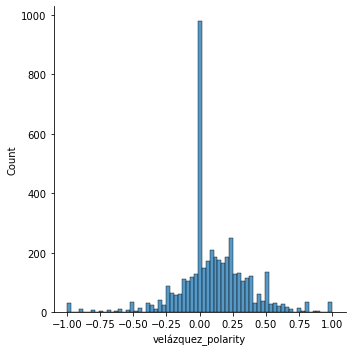

In [53]:
congress_tweets['velázquez_polarity']= velázquez_text.map(lambda text: TextBlob(text).sentiment.polarity)
sns.displot(congress_tweets, x='velázquez_polarity')
plt.show()

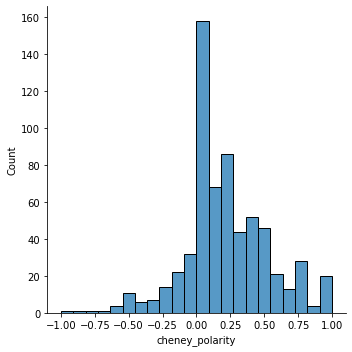

In [54]:
congress_tweets['cheney_polarity']= cheney_text.map(lambda text: TextBlob(text).sentiment.polarity)
sns.displot(congress_tweets, x='cheney_polarity')
plt.show()

<b>What do we see?</b>
According to the plots, both Senators' tweets are mostly nuetral. This matches what I'd assume, given that politicians tend to stay away from polarizing statements.

#### Subjectivity

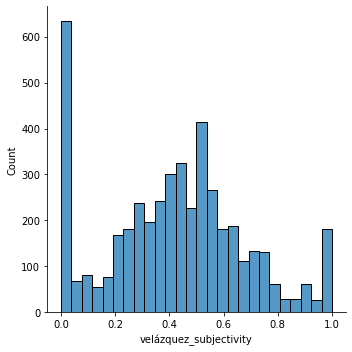

In [38]:
congress_tweets['velázquez_subjectivity'] = velázquez_text.map(lambda text: TextBlob(text).sentiment.subjectivity)
sns.displot(congress_tweets, x="velázquez_subjectivity")
plt.show()

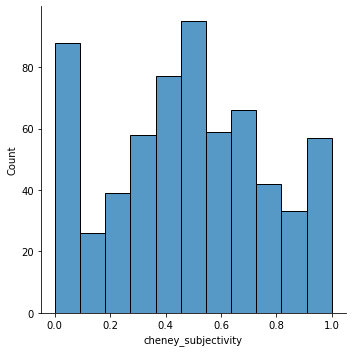

In [39]:
congress_tweets['cheney_subjectivity'] = cheney_text.map(lambda text: TextBlob(text).sentiment.subjectivity)
sns.displot(congress_tweets, x="cheney_subjectivity")
plt.show()

<b>What do we see?</b>
According to the plots, Senator Velázquez's tweets tend to be more objective. A significant portion of Senator Cheney's tweet are also objective, however Senator Cheney seems to have a mean closer to ~0.5. This may suggest that Democratic senators are more objective, however it may also be due to the much smaller sample from Senator Cheney.

#### Sentiment vs. Subjectivity

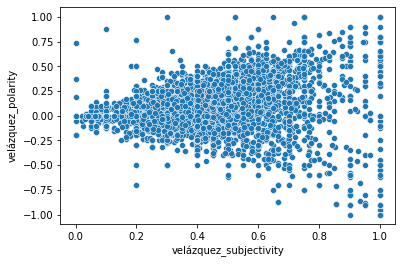

In [40]:
sns.scatterplot(data = congress_tweets, x = 'velázquez_subjectivity', y = 'velázquez_polarity')
plt.show()

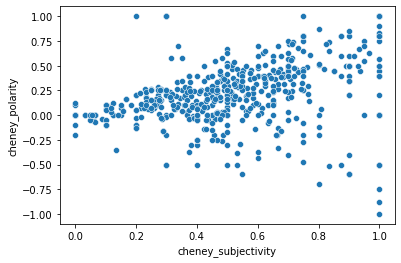

In [41]:
sns.scatterplot(data = congress_tweets, x = 'cheney_subjectivity', y = 'cheney_polarity')
plt.show()

<b>What do we see?</b>
According to the plots, both Senators' tweets become more polarizing as they become more subjective. In the case of Senator Cheney, however, this occurs in a much more positive direction than Senator Velázquez. This, again, may be due to the smaller sample size from Senator Cheney.

#### Democrats vs. Republicans

In [49]:
ct_sub['polarity']= ct_sub['tokens_str'].map(lambda text: TextBlob(text).sentiment.polarity)
ct_sub['subjectivity']= ct_sub['tokens_str'].map(lambda text: TextBlob(text).sentiment.subjectivity)

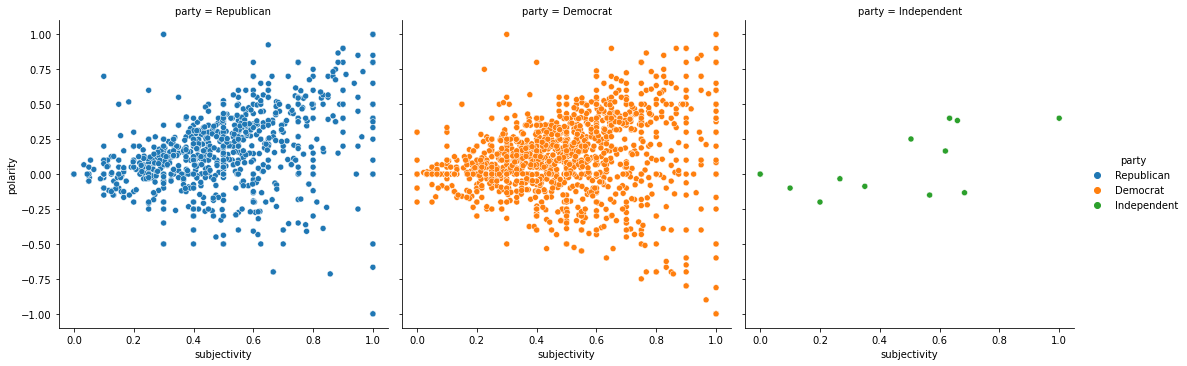

In [51]:
sns.relplot(
    data=ct_sub, x="subjectivity", y="polarity",
    col="party", hue = "party", kind="scatter"
)
plt.show()

<b>What do we see?</b>
These plots reveal a similar patter to the one we just saw between Senators Velázquez and Cheney. It seems that both parties' tweets become more positive as they get more subjective - although the relationship seems to be stronger for Republicans. This suggest what saw earlier was not due soley Senator Cheney's smaller sample size.

#### Senators vs. Representatives

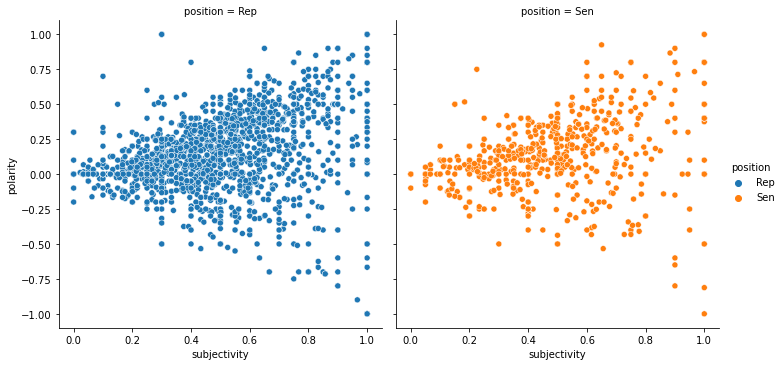

In [52]:
sns.relplot(
    data=ct_sub, x="subjectivity", y="polarity",
    col="position", hue = "position", kind="scatter"
)
plt.show()

<b>What do we see?</b>
Again, we see this same pattern. As tweets become mroe subjective, they also become more positive. The slight differences we see here are likely due to the composition of either chamber. For the 116th Congress, the Senate was majority Republican and the House was majority Democrat.

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features

In [ ]:
# Engineered Features
...

### Bag-of-words or Tf-idf

In [ ]:
# Frequency Based featurization
...

### Word Embedding

In [ ]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

#model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 

In [ ]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

In [ ]:
# embedding based featurization
...

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [ ]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])
...

### Two Combined Models

In [ ]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
...

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**Your Answer Here**

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**Your Answer Here**

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**Your Answer Here**

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**Your Answer Here**